In [ ]:
"""
The following shell commands are used to install various Python libraries via pip,
the Python package installer. These commands are typically run in environments such
as Jupyter notebooks or other Python interactive sessions that support shell commands
within the interface. The `--quiet` flag is included to reduce the verbosity of the
installation process, making the output cleaner and more concise. The libraries installed
are essential for data presentation, reinforcement learning, and deep learning, with
optional GPU support for the TensorFlow library.
"""

# Install the 'tabulate' library for pretty-printing tables.
!pip install tabulate --quiet

# Install the 'gymnasium' library, a toolkit for reinforcement learning.
!pip install gymnasium --quiet

# Install 'stable_baselines3', which includes implementations of RL algorithms.
!pip install stable_baselines3 --quiet

# Install 'tensorflow', with optional support for GPU acceleration.
!pip install tensorflow[and-cuda] --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.8/845.8 kB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
"""
This module imports necessary libraries and specific functions required for
building and running machine learning models, particularly for reinforcement learning tasks.
It includes libraries for numerical operations, data manipulation, plotting,
progress tracking, interaction with the operating system, and building both PyTorch and TensorFlow neural network models.
"""

import os
import torch
import random
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt

from gymnasium import spaces
from tqdm import tqdm
from tabulate import tabulate
from IPython.display import clear_output
from stable_baselines3 import PPO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from torch.distributions.normal import Normal
from tensorflow.keras.optimizers import Adam


In [ ]:
with open('../data/pickle/pairs.pkl', 'rb') as handle:
    pairs = pickle.load(handle)

In [ ]:
class Orderland(gym.Env):
    """
    A custom OpenAI Gym environment for simulating and optimizing order matching in a financial context.

    This environment simulates a scenario where there are forward sales and cash purchases that need to be matched.
    The agent's goal is to decide on actions that optimize the matching process according to the given heuristics.

    Attributes:
        pairs (dict): A dictionary containing the 'sale' and 'purchase' pairs.
        lp (float): A parameter used in calculating the maximum state.
        mr (float): A multiplier used in reward calculation.
        mbse (float): The base score used in the scoring function.
        state (np.array): The current state representation of the environment.
        crr_ep (int): The current episode index.
        crr_ix (int): The current index within the episode.
        crr_st (int): The current state index.
        crr_rd (float): The cumulative reward for the current episode.
        crr_an (int or None): The current action taken.
        max_st (int): The maximum state index for the current episode.
        lst_se (float): The last score achieved.
        act_qt (float): The quantity of action taken.
        di_history (list): A history of DI (Discount Index) values.
        state_history (list): A history of state indices.

    The environment defines an observation space and an action space using Gym spaces,
    which represent the possible states and actions that can be taken, respectively.
    """

    metadata = {'render.modes': ['human']}

    def __init__(self, pairs, lp, mr, mbse):
        """
        Initializes a new instance of the Orderland environment.

        Parameters:
            pairs (dict): A dictionary containing the 'sale' and 'purchase' data for the environment.
            lp (float): The lookahead parameter for determining the maximum number of steps.
            mr (float): The multiplier used in calculating the reward.
            mbse (float): The minimum base score expected from the environment.
        """
        super(Orderland, self).__init__()

        self.pairs = pairs
        self.keys = list(self.pairs.keys())
        self.lp = lp
        self.mr = mr
        self.mbse = mbse
        self.crr_ep = 0
        self.crr_ix = 0
        self.crr_st = 0
        self.crr_rd = 0
        self.state  = None
        self.crr_an = None
        self.max_st = None
        self.lst_se = None
        self.act_qt = None
        self.di_history = []
        self.state_history = []

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len([
            'Pending quantity of forward sale to be matched',
            'Available quantity of cash purchase',
            'Quantity of cash purchase already matched',
            'The absolute price difference between the ideal price for forward sale and the cash purchase price',
        ]),), dtype=np.float64)

        self.action_space = spaces.Discrete(len(
            [
                'Skip',
                'With 100%',
                'Withdraw 100%'
            ]
        ))

    def reset(self, seed=None, options=None):
        """
        Resets the environment to a new random state at the start of an episode.

        Parameters:
            seed (int, optional): A seed to ensure reproducibility. Defaults to None.
            options (dict, optional): Additional options for resetting the environment. Defaults to None.

        Returns:
            tuple: A tuple containing the initial state and an empty info dictionary.
        """
        self.crr_ep = np.random.randint(0, len(self.keys))
        self.crr_ix = np.random.randint(0, len(self.pairs[self.keys[self.crr_ep]]['sale']))
        self.crr_st = 0
        self.crr_rd = 0
        self.max_st = (len(self.pairs[self.keys[self.crr_ep]]['purchase']) - 1) * self.lp
        self.state = self.get_observation()
        return self.state, {}

    def get_observation(self):
        """
        Retrieves the current state of the environment as an observation.

        Returns:
            np.array: The current observation of the environment.
        """
        ep_data = self.pairs[self.keys[self.crr_ep]]
        crr_sal = ep_data['sale'][self.crr_ix]
        crr_pur = ep_data['purchase'].iloc[self.crr_st % ep_data['purchase'].shape[0]]

        return np.array(
            [
                crr_sal['pending_quantity'],
                crr_pur['available_quantity'],
                crr_pur['matched'],
                self.heur(crr_sal['ideal_price'], crr_pur['price'])
            ]
        )

    def heur(self, il_px, px):
        """
        A heuristic function that calculates the absolute price difference.

        Parameters:
            il_px (float): The ideal price for forward sale.
            px (float): The cash purchase price.

        Returns:
            float: The absolute price difference.
        """
        return abs(il_px - px)

    def step(self, action):
        """
        Advances the environment by one step according to the given action.

        Parameters:
            action (int): The action to take, represented as an integer.

        Returns:
            tuple: A tuple containing the new observation, reward, termination status, truncation status, and an empty info dictionary.
        """
        ep_data = self.pairs[self.keys[self.crr_ep]]

        if self.lst_se == None:
            self.lst_se = self.score()

        sca = self.score_of_taking_action(action)
        diff_rh = self.lst_se - sca

        bps = self.get_best_score()
        diff_tg = self.lst_se - bps

        reward = self.get_reward(diff_rh, diff_tg)

        self.do(action)
        self.crr_an = action
        self.crr_st += 1
        self.lst_se = sca

        observation = self.get_observation()

        terminated = False

        if observation[0] == 0:
            terminated = True

        truncated = False

        if self.crr_st > self.max_st:
            reward = -1.0
            truncated = True

        if action in [2] and ep_data['purchase'].iloc[self.crr_st % ep_data['purchase'].shape[0]]['matched'] == 0:
            reward = -1.0

        self.crr_rd += reward

        di_value = self.calculate_cdi(self.pairs[self.keys[self.crr_ep]]['sale'][self.crr_ix],
                                      self.pairs[self.keys[self.crr_ep]]['purchase'])
        if di_value is not None:
            self.di_history.append(di_value)
            self.state_history.append(self.crr_st)

        return observation, reward, terminated, truncated, {}

    def score(self):
        """
        Calculates the score of the current state based on the matched quantities and the heuristic function.

        The score is calculated as the weighted sum of the heuristic values for all matched purchases,
        weighted by the matched quantity. If no purchases have been matched, the minimum base score (mbse)
        is returned.

        Returns:
            float: The calculated score for the current state.
        """
        cum_matched = self.pairs[self.keys[self.crr_ep]]['purchase']['matched'].sum()

        if cum_matched == 0:
            return self.mbse

        il_px = self.pairs[self.keys[self.crr_ep]]['sale'][self.crr_ix]['ideal_price']

        cum_sum = 0

        for _, row in self.pairs[self.keys[self.crr_ep]]['purchase'].iterrows():
            cum_sum += self.heur(il_px, row['price']) * row['matched']

        return cum_sum/cum_matched

    def score_of_taking_action(self, action):
        """
        Evaluates the score after taking a given action by temporarily applying the action,
        calculating the score, and then undoing the action.

        Parameters:
            action (int): The action to evaluate.

        Returns:
            float: The score resulting from taking the given action.
        """
        self.do(action)
        score = self.score()
        self.undo(action)
        return score

    def do(self, action):
        """
        Executes the given action on the environment, affecting the state of the sales and purchases.

        Depending on the action, this method updates the matched and available quantities
        for the current sale and purchase.

        Parameters:
            action (int): The action to execute, represented by an integer.
        """
        ep_data = self.pairs[self.keys[self.crr_ep]]
        crr_sal = ep_data['sale'][self.crr_ix]
        row_index = self.crr_st % ep_data['purchase'].shape[0]
        crr_pur = ep_data['purchase'].iloc[row_index]

        if isinstance(action, np.ndarray):
            action = action.item()

        if action == 0:
            pass
        elif action == 1:
            self.act_qt = min(np.floor(crr_pur['available_quantity']), crr_sal['pending_quantity'])
            if self.act_qt <= crr_pur['available_quantity']:
                ep_data['purchase'].iloc[row_index, ep_data['purchase'].columns.get_loc('matched')] += self.act_qt
                ep_data['purchase'].iloc[row_index, ep_data['purchase'].columns.get_loc('available_quantity')] -= self.act_qt
                crr_sal['pending_quantity'] -= self.act_qt
            else:
                pass
        elif action == 2:
            self.act_qt = min(np.floor(crr_pur['matched']), crr_pur['matched'])
            ep_data['purchase'].iloc[row_index, ep_data['purchase'].columns.get_loc('matched')] -= self.act_qt
            ep_data['purchase'].iloc[row_index, ep_data['purchase'].columns.get_loc('available_quantity')] += self.act_qt
            crr_sal['pending_quantity'] += self.act_qt


    def undo(self, action):
        """
        Reverts the effects of the given action, restoring the previous state of sales and purchases.

        This method is used in conjunction with `do` to evaluate potential actions without permanently
        altering the state of the environment.

        Parameters:
            action (int): The action to undo.
        """
        ep_data = self.pairs[self.keys[self.crr_ep]]
        row_index = self.crr_st % ep_data['purchase'].shape[0]

        if isinstance(action, np.ndarray):
            action = action.item()

        if action == 0:
            pass
        elif action in [1]:
            ep_data['purchase'].iloc[row_index, ep_data['purchase'].columns.get_loc('matched')] -= self.act_qt
            ep_data['purchase'].iloc[row_index, ep_data['purchase'].columns.get_loc('available_quantity')] += self.act_qt
            ep_data['sale'][self.crr_ix]['pending_quantity'] += self.act_qt
        elif action in [2]:
            ep_data['purchase'].iloc[row_index, ep_data['purchase'].columns.get_loc('matched')] += self.act_qt
            ep_data['purchase'].iloc[row_index, ep_data['purchase'].columns.get_loc('available_quantity')] -= self.act_qt
            ep_data['sale'][self.crr_ix]['pending_quantity'] -= self.act_qt



    def get_best_score(self):
        """
        Determines the best possible score that can be achieved from the current state by evaluating
        all possible actions.

        Returns:
            float: The best score achievable from the current state.
        """
        btse = self.mbse

        for action in range(3):
            score = self.score_of_taking_action(action)
            if(score < btse):
                btse = score

        return btse

    def get_reward(self, diff_rh, diff_tg):
        """
        Calculates the reward for the agent's action based on the difference in heuristic values
        before and after the action, and the difference between the current and best possible scores.

        Parameters:
            diff_rh (float): The difference in heuristic value as a result of the action.
            diff_tg (float): The difference between the last score and the best possible score.

        Returns:
            float: The calculated reward for the action taken.
        """
        if diff_tg == 0:
            if diff_tg == diff_rh:
                return 0.76
            else:
                return np.tanh(0.2*(self.mr * diff_rh))

        return np.tanh(0.2*(self.mr * (diff_rh/diff_tg)))

    def calculate_cdi(self, sale_df, purchase_df):
        """
        Calculates the Composite Discount Index (CDI) based on the sale and purchase dataframes.

        The CDI is a measure that compares the price of sales and matched purchases, adjusted for
        the time difference and discount index.

        Parameters:
            sale_df (DataFrame): The dataframe containing sale data.
            purchase_df (DataFrame): The dataframe containing purchase data.

        Returns:
            float or None: The calculated CDI value, or None if the calculation is not possible.
        """
        sale_price = sale_df['price'] * sale_df['quantity']
        du =  sale_df['business_days_diff']
        di = sale_df['di']
        purchase_price = 0
        matched_purchases = purchase_df.loc[purchase_df['matched'] != 0]
        for index, row in matched_purchases.iterrows():
            purchase_price += row['price'] * row['matched']

        if purchase_price == 0 or du == 0 or di == 0:
            return None

        return ((sale_price/purchase_price)**(252/du) - 1)/di

    def render(self, mode='human', clear_screen=True):
        """
        Renders the current state of the environment to the console or other output.

        This method provides a human-readable display of the current state, including the current
        episode, index, state, last score, chosen action, action quantity, and accumulated reward.

        Parameters:
            mode (str): The mode of rendering ('human' for console output).
            clear_screen (bool): Whether to clear the console before rendering the new state.

        Note: If the mode is not 'human', it defaults to the superclass render method.
        """
        if mode == 'human':
            if clear_screen:
                clear_output(wait=True)

            headers = ["Description", "Value"]
            data = [
                ("Current Episode", self.crr_ep),
                ("Current Index", self.crr_ix),
                ("Current State", f"{self.crr_st}/{self.max_st}"),
                ("Last Score", self.lst_se),
                ("Chosen Action", self.crr_an),
                ("Action Quantity", self.act_qt),
                ("Accumulated Reward", f"{self.crr_rd:.2f}")
            ]

            ep_data = self.pairs[self.keys[self.crr_ep]]
            crr_sal = ep_data['sale'][self.crr_ix]
            crr_pur = ep_data['purchase'].iloc[self.crr_st % ep_data['purchase'].shape[0]]

            pending_quantity = crr_sal['pending_quantity']
            data.append(("Pending Quantity of Forward Sale to be Matched", pending_quantity))

            data.append(("DI", f"{self.calculate_cdi(crr_sal, ep_data['purchase'])}"))

            if pending_quantity == 0:
                data.append(("Sales Match Status", "All Sales Matched! [Match-Complete]"))

            print(tabulate(data, headers=headers, tablefmt="grid"))
        else:
            super(Orderland, self).render(mode=mode)

In [ ]:
class MatchNet:
    def __init__(self, state_size, action_size):
        """
        Initializes the MatchNet agent with the given state and action space sizes.

        Parameters:
            state_size (int): The dimensionality of the state space.
            action_size (int): The number of possible actions.

        Attributes:
            lr (float): Learning rate for the optimizer.
            gamma (float): Discount factor for future rewards.
            exploration_proba (float): Initial exploration probability.
            exploration_proba_decay (float): Exploration probability decay rate.
            batch_size (int): Batch size for the experience replay.
            memory_buffer (list): Buffer to store experience tuples.
            max_memory_buffer (int): Maximum size of the memory buffer.
            model (keras.Model): Sequential neural network model.
        """
        self.state_size = state_size
        self.action_size = action_size

        self.lr = 1e-4
        self.gamma = 0.99
        self.exploration_proba = 1.0
        self.exploration_proba_decay = 0.99706 #0.994 bom
        self.batch_size = 32

        self.memory_buffer = []
        self.max_memory_buffer = 2000

        self.model = Sequential([
            Dense(units=24, input_dim=state_size, activation='relu'),
            Dense(units=24, activation='relu'),
            Dense(units=action_size, activation='linear')
        ])
        self.model.compile(loss="mse", optimizer=Adam(learning_rate=self.lr))

    def compute_action(self, state):
        """
        Computes the action to take given the current state.

        This method uses an epsilon-greedy policy for exploration.

        Parameters:
            state (np.array): The current state.

        Returns:
            int: The action to take.
        """
        if np.random.rand() < self.exploration_proba:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1))[0]
        return np.argmax(q_values)

    def update_exploration_probability(self):
        """
        Updates the exploration probability using an exponential decay.
        """
        self.exploration_proba *= np.exp(-self.exploration_proba_decay)

    def store_episode(self, state, action, reward, next_state, done):
        """
        Stores an episode tuple in the memory buffer.

        Parameters:
            state (np.array): The initial state from the episode.
            action (int): The action taken.
            reward (float): The reward received.
            next_state (np.array): The resulting state after the action.
            done (bool): Whether the episode is finished.
        """
        self.memory_buffer.append((state, action, reward, next_state, done))
        if len(self.memory_buffer) > self.max_memory_buffer:
            self.memory_buffer.pop(0)

    def replay(self):
        """
        Trains the network using a batch of experiences from the memory buffer.
        """
        if len(self.memory_buffer) < self.batch_size:
            return
        batch_sample = np.random.choice(self.memory_buffer, self.batch_size)

        for state, action, reward, next_state, done in batch_sample:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1))[0])
            target_f = self.model.predict(state.reshape(1, -1))
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)

    def load(self, name):
        """
        Loads the model's weights from a file.

        Parameters:
            name (str): The name of the file to load the weights from.
        """
        self.model.load_weights(name)

    def save(self, name):
        """
        Saves the model's weights to a file.

        Parameters:
            name (str): The name of the file to save the weights to.
        """
        self.model.save_weights(name)


In [ ]:
import gym
import numpy as np
from gym import spaces

class FilippoTheFinancier:
    """
    FilippoTheFinancier is a class that encapsulates the process of training and running a DQN agent
    in a custom gym environment.
    """

    def __init__(self, env, state_size, action_size):
        """
        Initializes the FilippoTheFinancier with the given environment, state size, and action size.

        Parameters:
            env (gym.Env): The custom gym environment.
            state_size (int): The size of the state space.
            action_size (int): The size of the action space.
        """
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.agent = MatchNet(state_size, action_size)

    def train(self, episodes):
        """
        Trains the DQN agent with the environment.

        Parameters:
            episodes (int): The number of episodes to train the agent for.
        """
        terminated = False
        truncated = False

        for e in range(episodes):
            state = self.env.reset()
            while not terminated or truncated:
                action = self.agent.compute_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                self.agent.store_episode(state, action, reward, next_state, terminated or truncated)
                state = next_state
            self.agent.replay()
            self.agent.update_exploration_probability()

    def save_weights(self, filename):
        """
        Saves the trained agent's weights to a file.

        Parameters:
            filename (str): The file path where to save the agent's weights.
        """
        self.agent.save(filename)

    def load_weights(self, filepath):
        """
        Loads the trained agent's weights from a file.

        Parameters:
            filepath (str): The file path from where to load the agent's weights.
        """
        self.agent.load(filepath)

    def run(self):
        """
        Runs the DQN agent in the environment using the trained weights.

        """
        state = self.env.reset()
        state = state[0] if isinstance(state, tuple) else state
        terminated = False
        truncated = False

        while not (terminated or truncated):
            action = self.agent.compute_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            self.env.render()
            state = next_state[0] if isinstance(next_state, tuple) else next_state

            if terminated:
                print("Episode terminated")
            if truncated:
                print("Episode truncated")

    def evaluate(self, num_runs):
        """
        Evaluates the model by running it for a specified number of runs and recording the DI values.

        Parameters:
            num_runs (int): The number of runs to evaluate the model.
        """
        di_values = []
        for _ in tqdm(range(num_runs), desc="Evaluating", unit="run"):
            state = self.env.reset()
            state = state[0] if isinstance(state, tuple) else state
            terminated = False
            truncated = False

            while not (terminated or truncated):
                action = self.agent.compute_action(state)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                state = next_state[0] if isinstance(next_state, tuple) else next_state

            final_di = self.env.calculate_cdi(
                self.env.pairs[self.env.keys[self.env.crr_ep]]['sale'][self.env.crr_ix],
                self.env.pairs[self.env.keys[self.env.crr_ep]]['purchase']
            )
            if final_di is not None:
                di_values.append(final_di)

        self.plot_di_distribution(di_values)

    def plot_di_distribution(self, di_values):
            """
            Plots the distribution of DI values using Matplotlib and adds a vertical line at DI=1.
            Ensures that each integer DI value has its own bar.

            Parameters:
                di_values (list): A list of DI values to plot.
            """
            max_di = max(di_values)  # Find the maximum DI value
            bins = np.arange(0, max_di + 2) - 0.5  # Create bins with edges at every integer

            plt.figure(figsize=(10, 6))
            plt.hist(di_values, bins=bins, edgecolor='k', alpha=0.7)
            plt.axvline(x=1, color='r', linestyle='--', linewidth=2, label='DI = 1')
            plt.title('Distribution of DI Values')
            plt.xlabel('DI Value')
            plt.ylabel('Frequency')
            plt.xticks(np.arange(0, max_di + 1))  # Set x-ticks to be at every integer
            plt.legend()
            plt.grid(True)
            plt.show()

            return di_values

    def get_sale(self, crr_ep, crr_ix):
        keys = list(pairs.keys())
        ep_data = pairs[keys[crr_ep]]
        crr_sal = ep_data['sale'][crr_ix]
        return crr_sal

    def get_purchase(self, crr_ep, crr_ix):
        keys = list(pairs.keys())
        ep_data = pairs[keys[crr_ep]]
        crr_pur = ep_data['purchase']
        return crr_pur

# Assuming your Orderland class and MatchNet class are already defined as per the provided code

# Initialize the custom environment
env = Orderland(pairs, 10, 10, 1_000_000_000)

# Get the size of the state and action spaces
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Create an instance of FilippoTheFinancier
filippo = FilippoTheFinancier(env, state_size, action_size)

# Train the agent with the environment (if not already trained and weights are saved)
episodes = 130_000
filippo.train(episodes)
filippo.save_weights("agent.weights.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [ ]:
with open('../data/pickle/pairs_v2.pkl', 'rb') as handle:
    pairs = pickle.load(handle)

In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 2724                                |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 1                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 1/370                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.08349665579309118                 |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

In [ ]:
episode = 3677
index = 3

filippo.get_sale(episode, index)

id                                              10525A
key                   Cliente 22_PRIO3_PACC_2023-10-11
client                                      Cliente 22
execution_date                     2023-10-11 00:00:00
ticker                                           PRIO3
broker                                            PACC
quantity                                           540
price                                        50.341815
maturity_date                      2024-04-08 00:00:00
di                                            0.117632
business_days_diff                                 124
ideal_price                                  47.660964
pending_quantity                                   0.0
Name: 10524, dtype: object

In [ ]:
filippo.get_purchase(episode, index)

,key,client,execution_date,ticker,broker,quantity,price,matched,available_quantity
559094,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,1000,47.616170,0.0,1000
724931,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,1000,47.696110,540.0,460
1239703,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,500,51.508079,0.0,500
1239704,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,300,51.949836,0.0,300
1239705,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,800,46.474556,0.0,800
1239706,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,300,45.595979,0.0,300
1239707,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,600,50.561075,0.0,600
1239708,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,700,56.504617,0.0,700
1239709,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,300,53.270170,0.0,300
1239710,Cliente 22_PRIO3_PACC_2023-10-11,Cliente 22,2023-10-11,PRIO3,PACC,200,50.195354,0.0,200


In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 1927                                |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 0                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 4/430                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.023085765882093767                |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

In [ ]:
episode = 1927
index = 0

filippo.get_sale(episode, index)

id                                              5499A
key                   Cliente 3_LREN3_XPIN_2023-07-10
client                                      Cliente 3
execution_date                    2023-07-10 00:00:00
ticker                                          LREN3
broker                                           XPIN
quantity                                          105
price                                        20.03619
maturity_date                     2023-07-26 00:00:00
di                                           0.136621
business_days_diff                                 12
ideal_price                                  19.91438
pending_quantity                                  0.0
Name: 5498, dtype: object

In [ ]:
filippo.get_purchase(episode, index)

,key,client,execution_date,ticker,broker,quantity,price,matched,available_quantity
732270,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,2000,19.940890,0.0,2000
1235140,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,700,19.309230,0.0,700
1235141,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,800,23.481839,0.0,800
1235142,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,500,19.891294,105.0,395
1235143,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,600,19.879527,0.0,600
1235144,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,200,18.412010,0.0,200
1235145,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,700,18.487742,0.0,700
1235146,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,500,23.509141,0.0,500
1235147,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,400,20.204767,0.0,400
1235148,Cliente 3_LREN3_XPIN_2023-07-10,Cliente 3,2023-07-10,LREN3,XPIN,300,22.722613,0.0,300


In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 506                                 |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 6                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 1/440                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.0005076580559602029               |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

In [ ]:
episode = 506
index = 6

filippo.get_sale(episode, index)

id                                              1531A
key                   Cliente 4_ESPA3_XPIN_2023-07-11
client                                      Cliente 4
execution_date                    2023-07-11 00:00:00
ticker                                          ESPA3
broker                                           XPIN
quantity                                         1937
price                                        1.865509
maturity_date                     2023-07-27 00:00:00
di                                           0.136571
business_days_diff                                 12
ideal_price                                  1.854171
pending_quantity                                  0.0
Name: 1530, dtype: object

In [ ]:
filippo.get_purchase(episode, index)

,key,client,execution_date,ticker,broker,quantity,price,matched,available_quantity
852208,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,30000,1.853663,1937.0,28063
969383,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,700,1.759026,0.0,700
969384,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,600,1.898966,0.0,600
969385,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,400,1.764600,0.0,400
969386,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,200,2.158094,0.0,200
969387,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,800,1.987888,0.0,800
969388,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,400,1.978134,0.0,400
969389,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,800,1.945921,0.0,800
969390,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,300,1.785017,0.0,300
969391,Cliente 4_ESPA3_XPIN_2023-07-11,Cliente 4,2023-07-11,ESPA3,XPIN,100,1.963110,0.0,100


In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 2268                                |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 0                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 1/350                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.03546618139987956                 |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 8052                                |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 6                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 1/410                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.011774248336953619                |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 9592                                |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 1                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 1/310                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.05290698313349651                 |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 299                                 |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 0                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 2/430                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.17478069501489557                 |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 283                                 |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 1                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 1/500                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.010109867984347432                |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 1454                                |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 1                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 1/490                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.0008094311095163675               |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

In [ ]:
# Load the trained weights into the agent
filippo.load_weights("/content/agent.weights.h5")

# Run the agent in the environment
filippo.run()

+------------------------------------------------+-------------------------------------+
| Description                                    | Value                               |
+================================================+=====================================+
| Current Episode                                | 9440                                |
+------------------------------------------------+-------------------------------------+
| Current Index                                  | 4                                   |
+------------------------------------------------+-------------------------------------+
| Current State                                  | 7/640                               |
+------------------------------------------------+-------------------------------------+
| Last Score                                     | 0.02797452501737041                 |
+------------------------------------------------+-------------------------------------+
| Chosen Action      

Evaluating:   0%|          | 0/100 [00:00<?, ?run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:   2%|▏         | 2/100 [00:00<00:08, 11.68run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:   4%|▍         | 4/100 [00:00<00:07, 12.03run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:   6%|▌         | 6/100 [00:00<00:07, 12.17run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:   8%|▊         | 8/100 [00:00<00:07, 12.06run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  10%|█         | 10/100 [00:00<00:07, 11.99run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  12%|█▏        | 12/100 [00:00<00:07, 12.05run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Evaluating:  14%|█▍        | 14/100 [00:01<00:07, 12.04run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  16%|█▌        | 16/100 [00:01<00:06, 12.06run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  18%|█▊        | 18/100 [00:01<00:06, 12.04run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  20%|██        | 20/100 [00:01<00:08,  9.22run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  22%|██▏       | 22/100 [00:01<00:07,  9.99run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  24%|██▍       | 24/100 [00:02<00:07, 10.58run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  26%|██▌       | 26/100 [00:02<00:06, 11.04run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  28%|██▊       | 28/100 [00:02<00:08,  8.95run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  30%|███       | 30/100 [00:02<00:07,  9.65run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

Evaluating:  32%|███▏      | 32/100 [00:06<00:46,  1.47run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  34%|███▍      | 34/100 [00:07<00:32,  2.00run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating:  36%|███▌      | 36/100 [00:07<00:24,  2.67run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  38%|███▊      | 38/100 [00:07<00:17,  3.48run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Evaluating:  40%|████      | 40/100 [00:07<00:14,  4.20run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  42%|████▏     | 42/100 [00:07<00:11,  5.22run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  44%|████▍     | 44/100 [00:08<00:10,  5.38run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  46%|████▌     | 46/100 [00:08<00:08,  6.37run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  48%|████▊     | 48/100 [00:08<00:06,  7.46run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  50%|█████     | 50/100 [00:08<00:05,  8.39run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  52%|█████▏    | 52/100 [00:08<00:05,  9.26run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  54%|█████▍    | 54/100 [00:08<00:04,  9.95run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Evaluating:  56%|█████▌    | 56/100 [00:09<00:04, 10.47run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  58%|█████▊    | 58/100 [00:09<00:06,  6.10run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  60%|██████    | 60/100 [00:09<00:05,  7.16run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  62%|██████▏   | 62/100 [00:10<00:04,  8.16run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  64%|██████▍   | 64/100 [00:10<00:04,  8.92run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  66%|██████▌   | 66/100 [00:10<00:03,  8.59run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

Evaluating:  68%|██████▊   | 68/100 [00:50<03:14,  6.09s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating:  70%|███████   | 70/100 [00:50<02:08,  4.29s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

Evaluating:  70%|███████   | 70/100 [01:10<02:08,  4.29s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

Evaluating:  71%|███████   | 71/100 [01:36<05:37, 11.64s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating:  73%|███████▎  | 73/100 [01:36<03:29,  7.76s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  75%|███████▌  | 75/100 [01:36<02:11,  5.28s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  77%|███████▋  | 77/100 [01:37<01:23,  3.63s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  79%|███████▉  | 79/100 [01:37<00:53,  2.53s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating:  81%|████████  | 81/100 [01:37<00:33,  1.78s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating:  83%|████████▎ | 83/100 [01:37<00:21,  1.26s/run]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  85%|████████▌ | 85/100 [01:38<00:14,  1.05run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating:  86%|████████▌ | 86/100 [01:38<00:11,  1.22run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating:  88%|████████▊ | 88/100 [01:38<00:06,  1.76run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating:  90%|█████████ | 90/100 [01:38<00:04,  2.44run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating:  92%|█████████▏| 92/100 [01:38<00:02,  3.28run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  94%|█████████▍| 94/100 [01:38<00:01,  4.24run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  96%|█████████▌| 96/100 [01:39<00:00,  5.32run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating:  98%|█████████▊| 98/100 [01:39<00:00,  6.01run/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating: 100%|██████████| 100/100 [01:39<00:00,  1.00run/s]


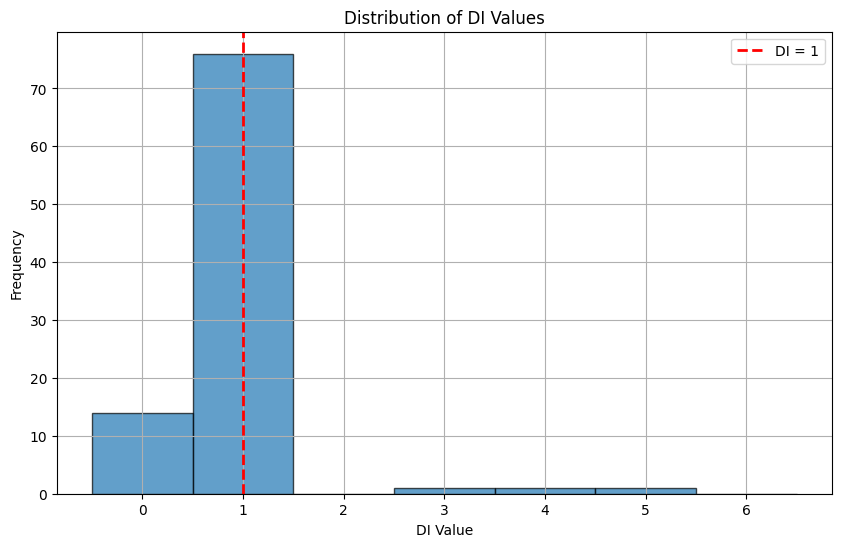

In [ ]:
num_runs = 100
filippo.evaluate(num_runs)

Evaluating: 100%|██████████| 200/200 [01:25<00:00,  2.33run/s]


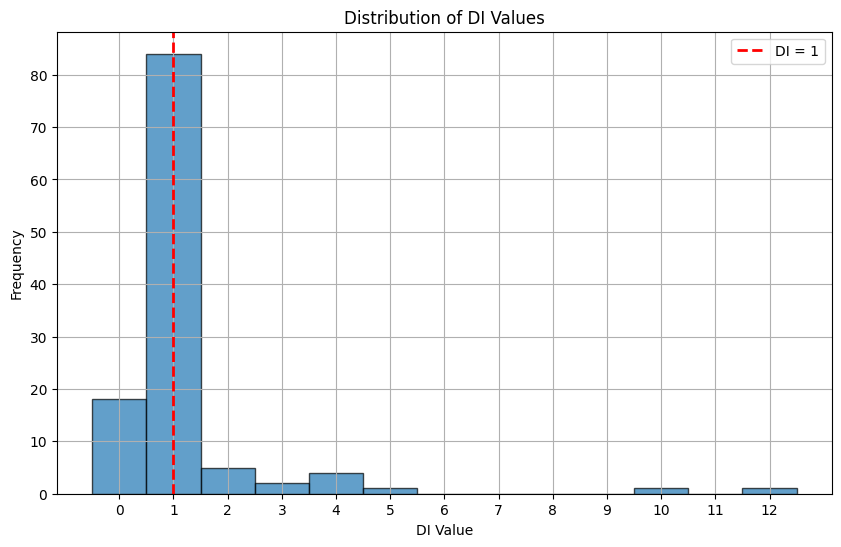

In [ ]:
num_runs = 200
filippo.evaluate(num_runs)

Evaluating: 100%|██████████| 300/300 [01:56<00:00,  2.59run/s]


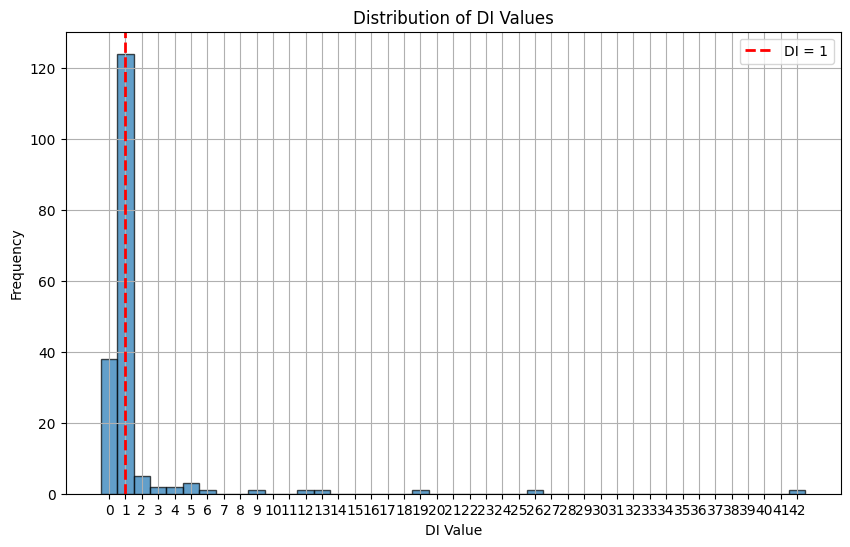

In [ ]:
num_runs = 300
di_values = filippo.evaluate(num_runs)
df = pd.DataFrame(di_values, columns=['di_value'])